In [6]:
## Load all the dependencies
import os
import sys
import random
import warnings
import numpy as np
from itertools import chain
from numpy import genfromtxt
from tensorflow import random
from keras import backend as K
# from keras import backend as k
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, UpSampling2D, GlobalAveragePooling2D, Multiply, Dense, Reshape, Permute, multiply, dot, add, Input
from keras.layers.core import Dropout, Lambda, SpatialDropout2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model, model_from_yaml, Sequential

import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

np.random.seed(1337) # for reproducibility
random.set_seed(1337)
print(tf.__version__)

name = "model_fine_tuning_"

2.1.0


In [3]:
# Use dice coefficient function as the loss function 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

# Jacard coefficient
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# calculate loss value
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# calculate loss value
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def Residual_CNN_block(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    return conv

class multiplication(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,x_query,phi_g,x_value = inputs[0],inputs[1],inputs[2],inputs[3],inputs[4]
        h,w,c = int(x.shape[1]),int(x.shape[2]),int(x.shape[3])
        x_query = K.reshape(x_query, shape=(-1,h*w, self.inter_channel//4))
        phi_g = K.reshape(phi_g,shape=(-1,h*w,self.inter_channel//4))
        x_value = K.reshape(x_value,shape=(-1,h*w,c))
        scale = dot([K.permute_dimensions(phi_g,(0,2,1)), x_query], axes=(1, 2))
        soft_scale = Activation('softmax')(scale)
        scaled_value = dot([K.permute_dimensions(soft_scale,(0,2,1)),K.permute_dimensions(x_value,(0,2,1))],axes=(1, 2))
        scaled_value = K.reshape(scaled_value, shape=(-1,h,w,c))        
        customize_multi = self.k * scaled_value
        layero = add([customize_multi,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([layero,g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*3)
    def get_custom_objects():
        return {'multiplication': multiplication}

def attention_up_and_concatenate(inputs):
    g,x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel, (2,2), strides=[2, 2],padding='same')(g)
    x_query = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    x_value = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    inputs = [g,x,x_query,phi_g,x_value]
    concate = multiplication(inter_channel)(inputs)
    return concate

class multiplication2(Layer):
    def __init__(self,inter_channel = None,**kwargs):
        super(multiplication2, self).__init__(**kwargs)
        self.inter_channel = inter_channel
    def build(self,input_shape=None):
        self.k = self.add_weight(name='k',shape=(1,),initializer='zeros',dtype='float32',trainable=True)
    def get_config(self):
        base_config = super(multiplication2, self).get_config()
        config = {'inter_channel':self.inter_channel}
        return dict(list(base_config.items()) + list(config.items()))  
    def call(self,inputs):
        g,x,rate = inputs[0],inputs[1],inputs[2]
        scaled_value = multiply([x, rate])
        att_x =  self.k * scaled_value
        att_x = add([att_x,x])
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
        concate = my_concat([att_x, g])
        return concate 
    def compute_output_shape(self,input_shape):
        ll = list(input_shape)[1]
        return (None,ll[1],ll[1],ll[3]*2)
    def get_custom_objects():
        return {'multiplication2': multiplication2}

def attention_up_and_concatenate2(inputs):
    g, x = inputs[0],inputs[1]
    inter_channel = g.get_shape().as_list()[3]
    g = Conv2DTranspose(inter_channel//2, (3,3), strides=[2, 2],padding='same')(g)
    g = Conv2D(inter_channel//2, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    theta_x = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(x)
    phi_g = Conv2D(inter_channel//4, [1, 1], strides=[1, 1], data_format='channels_last')(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format='channels_last')(f)
    rate = Activation('sigmoid')(psi_f)
    concate =  multiplication2()([g,x,rate])
    return concate

# Train last 4 layers

In [3]:
loaded_model = load_model('June21/model/model_augv_attention2.h5', 
                             custom_objects={'multiplication': multiplication,'multiplication2': multiplication2, 
                                             'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef,})

order= 'Last4_'

# remove the last 2 layer using pop() function
loaded_model.layers.pop()
loaded_model.layers.pop()

for (index, layer) in enumerate(loaded_model.layers):
    if (index > len(loaded_model.layers)-5):
        print("Here")
        layer.trainable = True
    else:
        layer.trainable = False

# Create new model from the model using the input and output of the last layer (after poping last 2 layers)
# model_without_last = Model(loaded_model.input,  loaded_model.layers[-1].output)
model_without_last = Model(loaded_model.input,  loaded_model.output)

# model_without_last.trainable = False

# See model structure
# model_without_last.summary()

Here
Here
Here
Here


# Train First 4 layers

In [8]:
loaded_model = load_model('June21/model/model_augv_attention2.h5', 
                             custom_objects={'multiplication': multiplication,'multiplication2': multiplication2, 
                                             'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef,})
order= 'First4_'

# remove the last 2 layer using pop() function
loaded_model.layers.pop()
loaded_model.layers.pop()

for (index, layer) in enumerate(loaded_model.layers):
    if (index < 4):
        print("index ",index)
        layer.trainable = True
    else:
        layer.trainable = False

# Create new model from the model using the input and output of the last layer (after poping last 2 layers)
model_without_last = Model(loaded_model.input,  loaded_model.layers[-1].output)

# See model structure
#model_without_last.summary()

index  0
index  1
index  2
index  3


In [9]:
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1

# 1 dimensional convolution and generate probabilities from Sigmoid function
conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1), name='conv2d_last')(model_without_last.output)
new_out = Activation('sigmoid', name='activation_last')(conv_final)

# Created new model with the newly added last two layers 
transfered_model = Model(inputs=model_without_last.input, outputs=new_out)

# New model structure
# transfered_model.summary()

# If want to train on the data **without** the NAIP, run the block below.

https://github.com/keras-team/keras/issues/3653#issuecomment-557844450 //how to implement sample_weights


In [10]:
data_path = 'Covington_data/without_NAIP/nodata_as_0/'
name += 'No_NAIP_'+'First4_'
# read in training and validation data
X_train = np.load(data_path+'train_data.npy')
Y_train = np.load(data_path+'train_label.npy')
X_Validation = np.load(data_path+'vali_data.npy')
Y_Validation = np.load(data_path+'vali_label.npy')

# The dataset has 9 channels:
# 0. Curvature
# 1. Slope
# 2. Openness
# 3. DEM
# 4. TPI 21
# 5. Reflectance (LiDAR intensity)
# 6. Geomorphon
# 7. TPI 9
# 8. TPI 3

# # ##############################################
# # 100 samples 
# X_train_new = X_train[0:80,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:80,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:20,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:20,:,:,:]
# print(Y_Validation.shape)
# name += "100_samples"
# # ##############################################

# # ##############################################
# # 90 samples 
# X_train_new = X_train[0:72,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:72,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:18,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:18,:,:,:]
# print(Y_Validation.shape)
# name += "90_samples_"
# # ##############################################

# # ##############################################
# # 80 samples 
# X_train_new = X_train[0:64,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:64,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:16,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:16,:,:,:]
# print(Y_Validation.shape)
# name += "80_samples_"
# # ##############################################

# ##############################################
# 70 samples 
X_train_new = X_train[0:56,:,:,:]
print(X_train_new.shape)
Y_train = np.load(data_path+'train_label.npy')[0:56,:,:,:]
print(Y_train.shape)

X_Validation_new = X_Validation[0:14,:,:,:]
print(X_Validation_new.shape)
Y_Validation = np.load(data_path+'vali_label.npy')[0:14,:,:,:]
print(Y_Validation.shape)
name += "70_samples_"
# ##############################################

# # ##############################################
# # 60 samples 
# X_train_new = X_train[0:48,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:48,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:12,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:12,:,:,:]
# print(Y_Validation.shape)
# name += "60_samples_"
# # ##############################################

# # ##############################################
# # 50 samples 
# X_train_new = X_train[0:40,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:40,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:10,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:10,:,:,:]
# print(Y_Validation.shape)
# name += "50_samples_"
# # ##############################################

# # ##############################################
# # 40 samples 
# X_train_new = X_train[0:32,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:32,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:8,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:8,:,:,:]
# print(Y_Validation.shape)
# name += "40_samples_"
# # ##############################################

# # ##############################################
# # 30 samples 
# X_train_new = X_train[0:24,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:24,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:6,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:6,:,:,:]
# print(Y_Validation.shape)
# name += "30_samples_"
# # ##############################################

# ##############################################
# # 20 samples 
# X_train_new = X_train[0:16,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:16,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:4,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:4,:,:,:]
# print(Y_Validation.shape)
# name += "20_samples_"
# ##############################################


# ##############################################
# # 10 samples 
# X_train_new = X_train[0:8,:,:,:]
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')[0:8,:,:,:]
# print(Y_train.shape)

# X_Validation_new = X_Validation[0:2,:,:,:]
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')[0:2,:,:,:]
# print(Y_Validation.shape)
# name += "10_samples_"
# ##############################################



# ##############################################
# # 1200 samples 
# X_train_new = X_train
# print(X_train_new.shape)
# Y_train = np.load(data_path+'train_label.npy')
# print(Y_train.shape)

# X_Validation_new = X_Validation
# print(X_Validation_new.shape)
# Y_Validation = np.load(data_path+'vali_label.npy')
# print(Y_Validation.shape)
# ##############################################

(56, 224, 224, 8)
(56, 224, 224, 1)
(14, 224, 224, 8)
(14, 224, 224, 1)


# If want to train on the data **with** the NAIP, run the block below.

In [ ]:
# data_path = 'Covington_data/include_NAIP/nodata_as_0/100_samples/'
# data_path = 'Covington_data/include_NAIP/nodata_as_0/350_samples/'
data_path = 'Covington_data/include_NAIP/nodata_as_0/500_samples/'

# read in training and validation sample patches
X_train_new = np.load(data_path+'train_data.npy')
X_Validation_new = np.load(data_path+'vali_data.npy')
print(X_train_new.shape)
print(X_Validation_new.shape)

#Read training and validation labels
Y_Validation = np.load(data_path+'vali_label.npy')
Y_train = np.load(data_path+'train_label.npy')

#Cast both labales to float32
Y_Validation = Y_Validation.astype(np.float32)
Y_train = Y_train.astype(np.float32)

## First pass 

In [11]:
patch_size = 224
IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
# Number of feature channels 
INPUT_CHANNELS = 8
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
maxepoch = 25
# hyperparameters
# learning_rate = 0.0000359
# learning_rate = 0.0001
learning_rate = 0.001
patience = 20
aug = 'v'
transfered_model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss, metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience+10, verbose=0),
        ModelCheckpoint('first_pass_model'+aug+'_attention2.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

print(name)

model_fine_tuning_No_NAIP_First4_70_samples_


In [12]:
fine_tuned_model_P1_history = transfered_model.fit(X_train_new, Y_train, validation_data=(X_Validation_new,Y_Validation), batch_size=2, epochs=maxepoch, callbacks=callbacks)

Train on 56 samples, validate on 14 samples
Epoch 1/25
56/56 [==============================] - 45s 795ms/step - loss: -0.0879 - dice_coef: 0.0879 - accuracy: 0.3949 - val_loss: -0.0459 - val_dice_coef: 0.0459 - val_accuracy: 0.8864
Epoch 2/25
56/56 [==============================] - 40s 719ms/step - loss: -0.1122 - dice_coef: 0.1122 - accuracy: 0.9193 - val_loss: -0.0490 - val_dice_coef: 0.0490 - val_accuracy: 0.9792
Epoch 3/25
56/56 [==============================] - 40s 719ms/step - loss: -0.1421 - dice_coef: 0.1421 - accuracy: 0.9563 - val_loss: -0.0580 - val_dice_coef: 0.0580 - val_accuracy: 0.9834
Epoch 4/25
56/56 [==============================] - 40s 719ms/step - loss: -0.1734 - dice_coef: 0.1734 - accuracy: 0.9553 - val_loss: -0.0932 - val_dice_coef: 0.0932 - val_accuracy: 0.9694
Epoch 5/25
56/56 [==============================] - 40s 719ms/step - loss: -0.2192 - dice_coef: 0.2192 - accuracy: 0.9567 - val_loss: -0.1271 - val_dice_coef: 0.1271 - val_accuracy: 0.9079
Epoch 6/25


In [8]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
name_p1 = name+"P1_"+timestr
# save the trained model
root_path = './vary_small_samples/training_results/10/'
model_yaml = transfered_model.to_yaml()
with open(root_path+name_p1+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# save the weights
transfered_model.save(root_path+name_p1+".h5")
# save the intermdediate rescults and training statistics
with open(root_path+name_p1+".pickle", 'wb') as file_pi:
    pickle.dump(fine_tuned_model_P1_history.history, file_pi, protocol=2)

print(root_path+name_p1+".h5")


from IPython.display import Audio
sound_file = '../wink.mp3'
Audio(sound_file, autoplay=True)

./vary_small_samples/training_results/10/model_fine_tuning_No_NAIP_First4_70_samples_P1_20210227-162133.h5


## Second pass

In [7]:
# transfered_model = load_model("./vary_small_samples/training_results/10/model_fine_tuning_No_NAIP_First4_70_samples_P1_20210227-162133.h5", 
#                              custom_objects={'multiplication': multiplication,'multiplication2': multiplication2, 
#                                              'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef,})

for (index, layer) in enumerate(transfered_model.layers):
    layer.trainable = True

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [8]:
for (index, layer) in enumerate(transfered_model.layers):
    layer.trainable = True

In [10]:
patch_size = 224
IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
# Number of feature channels 
INPUT_CHANNELS = 8
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
maxepoch = 25
# hyperparameters
# 100 times smaller learning rate
learning_rate = 0.0000359
patience = 20
aug = 'v'
transfered_model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience+10, verbose=0),
        ModelCheckpoint('second_pass_model'+aug+'_attention2.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

name += str(maxepoch*2)+'_epoch_'
print(name)

model_fine_tuning_No_NAIP_First4_70_samples_50_epoch_


In [7]:
fine_tuned_model_P2_history = transfered_model.fit(X_train_new, Y_train, validation_data=(X_Validation_new,Y_Validation), batch_size=1, epochs=maxepoch, callbacks=callbacks)

Train on 80 samples, validate on 20 samples
Epoch 1/25
80/80 [==============================] - 71s 893ms/step - loss: -0.4622 - dice_coef: 0.4622 - accuracy: 0.9676 - val_loss: -0.2082 - val_dice_coef: 0.2082 - val_accuracy: 0.9763
Epoch 2/25
80/80 [==============================] - 68s 846ms/step - loss: -0.4635 - dice_coef: 0.4635 - accuracy: 0.9678 - val_loss: -0.2096 - val_dice_coef: 0.2096 - val_accuracy: 0.9759
Epoch 3/25
80/80 [==============================] - 68s 848ms/step - loss: -0.4642 - dice_coef: 0.4642 - accuracy: 0.9678 - val_loss: -0.2088 - val_dice_coef: 0.2088 - val_accuracy: 0.9759
Epoch 4/25
80/80 [==============================] - 68s 850ms/step - loss: -0.4650 - dice_coef: 0.4650 - accuracy: 0.9679 - val_loss: -0.2087 - val_dice_coef: 0.2087 - val_accuracy: 0.9759
Epoch 5/25
80/80 [==============================] - 68s 849ms/step - loss: -0.4657 - dice_coef: 0.4657 - accuracy: 0.9680 - val_loss: -0.2092 - val_dice_coef: 0.2092 - val_accuracy: 0.9759
Epoch 6/25


In [8]:
import pickle
name_p2 = "model_fine_tuning_No_NAIP_First4_70_samples_P2_20210227-162133"
# save the trained model
root_path = './vary_small_samples/training_results/10/'
model_yaml = transfered_model.to_yaml()
with open(root_path+name_p2+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# save the weights
transfered_model.save(root_path+name_p2+".h5")
# save the intermdediate rescults and training statistics
with open(root_path+name_p2+".pickle", 'wb') as file_pi:
    pickle.dump(fine_tuned_model_P2_history.history, file_pi, protocol=2)

from IPython.display import Audio
sound_file = '../wink.mp3'

Audio(sound_file, autoplay=True)

## Plots 

In [14]:
# first pass 
training_loss = fine_tuned_model_P1_history.history['loss']
validation_loss = fine_tuned_model_P1_history.history['val_loss']

training_accuracy = fine_tuned_model_P1_history.history['accuracy']
validation_accuracy = fine_tuned_model_P1_history.history['val_accuracy']

training_dice = fine_tuned_model_P1_history.history['dice_coef']
validation_dice = fine_tuned_model_P1_history.history['val_dice_coef']

# fine_tuned_model.history

training_loss += fine_tuned_model_P2_history.history['loss']
validation_loss += fine_tuned_model_P2_history.history['val_loss']

training_accuracy += fine_tuned_model_P2_history.history['accuracy']
validation_accuracy +=  fine_tuned_model_P2_history.history['val_accuracy']

training_dice += fine_tuned_model_P2_history.history['dice_coef']
validation_dice +=  fine_tuned_model_P2_history.history['val_dice_coef']



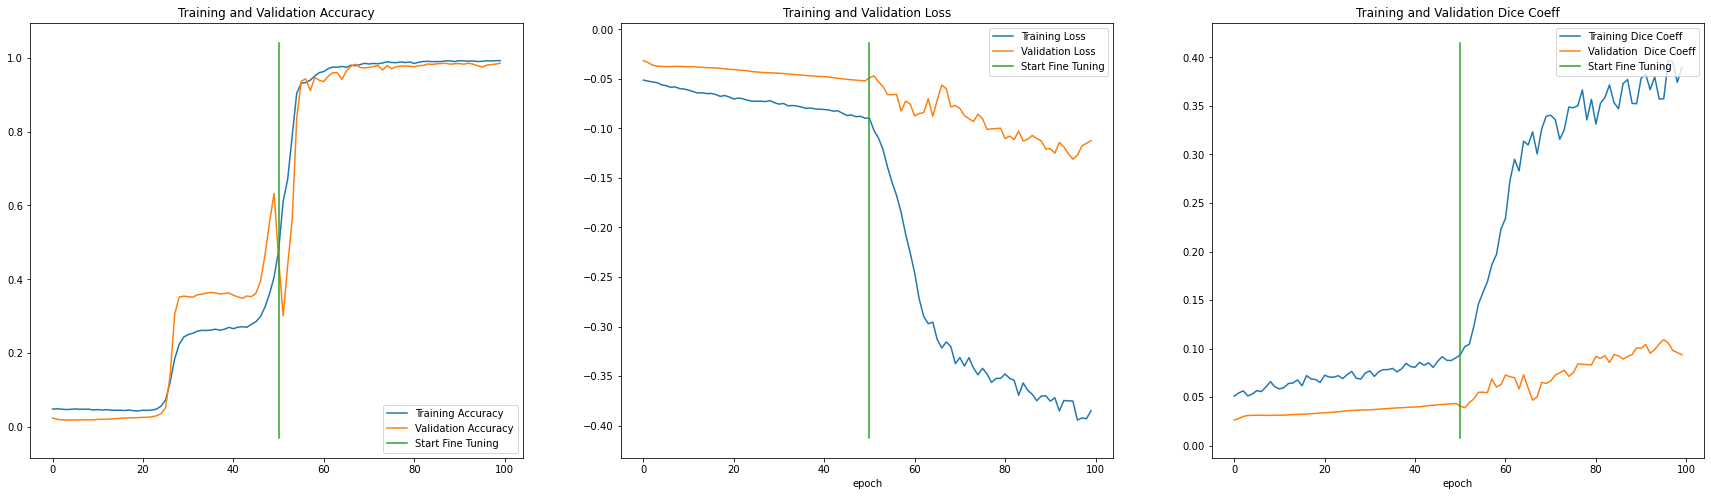

In [15]:

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 8))
plt.subplot(1,3, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
# plt.ylim([0, 1])
plt.plot([50,50], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([50,50],  plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(training_dice, label='Training Dice Coeff')
plt.plot(validation_dice, label='Validation  Dice Coeff')
# plt.ylim([0, 1.0])
plt.plot([50,50],  plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Coeff')
plt.xlabel('epoch')

plt.show()

#   

--- 

.


 

In [21]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
root_path = './training_results/Without_NAIP/'
# save the trained model
model_yaml = transfered_model.to_yaml()
with open(root_path+"model_transfere_learning_No_NAIP_700_samples_"+timestr+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# save the weights
transfered_model.save(root_path+"model_transfere_learning_No_NAIP_700_samples_"+timestr+".h5")
# save the intermdediate results and training statistics
with open(root_path+"history_transfere_learning_No_NAIP_700_samples_"+timestr+".pickle", 'wb') as file_pi:
    pickle.dump(ltranfer_learning_results.history, file_pi, protocol=2)

### Will wait for the whole area data to do prediction

In [5]:
root_path = './training_results/Without_NAIP/'
loaded_model = load_model(root_path+"model_transfere_learning_No_NAIP_700_samples_20201116-121041.h5", 
                             custom_objects={'multiplication': multiplication,'multiplication2': multiplication2, 
                                             'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef,})

for (index, layer) in enumerate(loaded_model.layers):
    layer.trainable = True


In [6]:
patch_size = 224
IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
# Number of feature channels 
INPUT_CHANNELS = 8
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
maxepoch = 100
# hyperparameters
# 100 times smaller learning rate
learning_rate = 0.0000359
patience = 20
aug = 'v'
loaded_model.compile(optimizer=Adam(lr=learning_rate),loss = dice_coef_loss,metrics=[dice_coef,'accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=patience, min_lr=1e-9, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience+10, verbose=0),
        ModelCheckpoint('model'+aug+'_attention2.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

In [7]:
fine_tuned_model = loaded_model.fit(X_train_new, Y_train, validation_data=(X_Validation_new,Y_Validation), batch_size=2, epochs=maxepoch, callbacks=callbacks)

Train on 350 samples, validate on 350 samples
Epoch 1/100
350/350 [==============================] - 43s 122ms/step - loss: -0.1419 - dice_coef: 0.1419 - accuracy: 0.9432 - val_loss: -0.0814 - val_dice_coef: 0.0814 - val_accuracy: 0.9769
Epoch 2/100
350/350 [==============================] - 29s 84ms/step - loss: -0.1457 - dice_coef: 0.1457 - accuracy: 0.9539 - val_loss: -0.0830 - val_dice_coef: 0.0830 - val_accuracy: 0.9652
Epoch 3/100
350/350 [==============================] - 29s 84ms/step - loss: -0.1485 - dice_coef: 0.1485 - accuracy: 0.9582 - val_loss: -0.0862 - val_dice_coef: 0.0862 - val_accuracy: 0.9656
Epoch 4/100
350/350 [==============================] - 29s 84ms/step - loss: -0.1510 - dice_coef: 0.1510 - accuracy: 0.9650 - val_loss: -0.0866 - val_dice_coef: 0.0866 - val_accuracy: 0.9747
Epoch 5/100
350/350 [==============================] - 29s 84ms/step - loss: -0.1524 - dice_coef: 0.1524 - accuracy: 0.9678 - val_loss: -0.0845 - val_dice_coef: 0.0845 - val_accuracy: 0.971

In [8]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
root_path = './training_results/Without_NAIP/'
# save the trained model
model_yaml = loaded_model.to_yaml()
with open(root_path+"model_fine_tuning_No_NAIP_700_samples"+timestr+".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# save the weights
loaded_model.save(root_path+"model_fine_tuning_learning_No_NAIP_700_samples"+timestr+".h5")
# save the intermdediate results and training statistics
with open(root_path+"history_fine_tuning_learning_No_NAIP_700_samples"+timestr+".pickle", 'wb') as file_pi:
    pickle.dump(fine_tuned_model.history, file_pi, protocol=2)